In [ ]:
#https://dataorigami.net/blogs/napkin-folding/18868411-lifetimes-measuring-customer-lifetime-value-in-python

In [8]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.display.width=200
import matplotlib.pyplot as plt
plt.interactive(True)
%matplotlib inline 

In [2]:
from lifetimes.datasets import load_cdnow_summary

In [24]:
data = load_cdnow_summary(index_col=[0])
data.reset_index().head()

,ID,frequency,recency,T
0,1,2,30.43,38.86
1,2,1,1.71,38.86
2,3,0,0.00,38.86
3,4,0,0.00,38.86
4,5,0,0.00,38.86


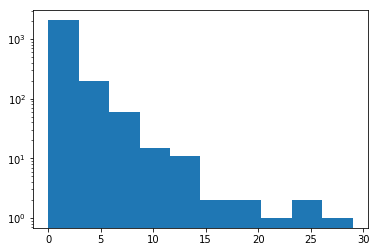

In [12]:
_ = plt.hist(data.frequency)
plt.yscale('log')

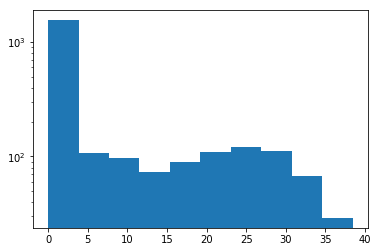

In [13]:
_ = plt.hist(data.recency)
plt.yscale('log')

In [6]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter()
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


## Visualizing our Frequency/Recency Matrix

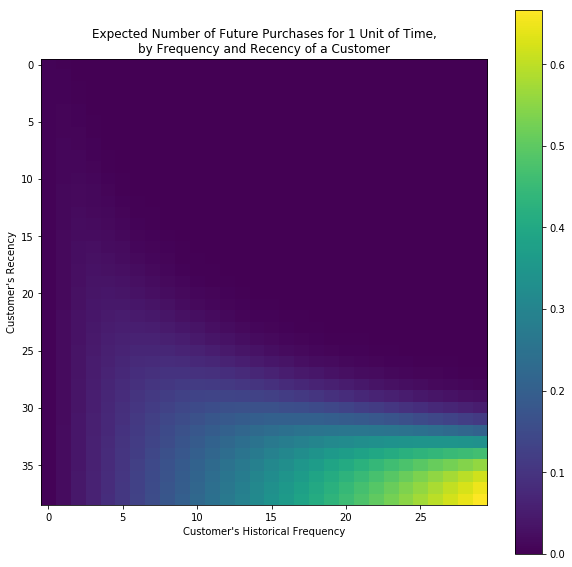

In [19]:
from lifetimes.plotting import plot_frequency_recency_matrix
plt.figure(figsize=(10,10))
plot_frequency_recency_matrix(bgf)

## Ranking customers from best to worst

In [23]:
t = 1
data['predicted_purchases'] = data.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(
                            t, r['frequency'], r['recency'], r['T']), axis=1)
data.sort_values('predicted_purchases',ascending=False).reset_index().head(5)

,ID,frequency,recency,T,predicted_purchases
0,1516,26,30.86,31.00,0.710623
1,157,29,37.71,38.00,0.662396
2,1981,17,28.43,28.86,0.486526
3,841,19,34.00,34.14,0.474738
4,509,18,35.14,35.86,0.424877


## Assessing model fit

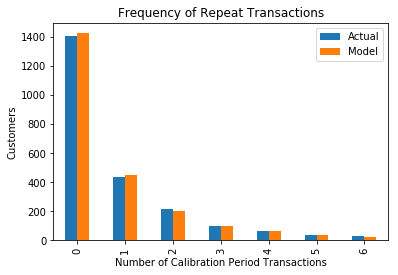

In [25]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Example using transactional datasets (convert transactional --> Lifetimes)

In [27]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
transaction_data.head()

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


In [30]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
summary.reset_index().head()

,id,frequency,recency,T
0,0,0.0,0.0,298.0
1,1,0.0,0.0,224.0
2,2,6.0,142.0,292.0
3,3,0.0,0.0,147.0
4,4,2.0,9.0,183.0


## More model fitting

In [33]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date', 
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )   
summary_cal_holdout.reset_index().head(10)

,id,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
0,0,0.0,0.0,177.0,0.0,121
1,1,0.0,0.0,103.0,0.0,121
2,2,6.0,142.0,171.0,0.0,121
3,3,0.0,0.0,26.0,0.0,121
4,4,2.0,9.0,62.0,0.0,121
5,5,1.0,77.0,130.0,0.0,121
6,6,0.0,0.0,29.0,0.0,121
7,7,1.0,1.0,195.0,0.0,121
8,8,1.0,80.0,93.0,0.0,121
9,9,1.0,1.0,188.0,0.0,121


<Figure size 864x864 with 0 Axes>

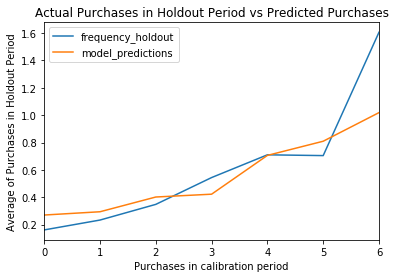

In [36]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plt.figure(figsize=(12,12))
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## Customer Predicitions

In [41]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
print(individual)
# The below function may be renamed to `predict` in a future version of lifetimes
bgf.conditional_expected_number_of_purchases_up_to_time(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

frequency      2.0
recency       96.0
T            159.0
Name: 20, dtype: float64


0.05765116591827167